In [28]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
from matplotlib.ticker import MaxNLocator
import matplotlib.cbook as cbook
import matplotlib.dates as mdates

Data Retrieval

In [29]:

# Connect to Google
# Scope: Enable access to specific links
scope = ['https://www.googleapis.com/auth/spreadsheets', "https://www.googleapis.com/auth/drive"]

credentials = ServiceAccountCredentials.from_json_keyfile_name("./gscredentials.json", scope)

client = gspread.authorize(credentials)

# Open the Google Sheet
sheet_id = '1CxCLvg2CGSHYNWskSa8JlBOPmF4th4XPEQQfy6AouYw'

sheet = client.open_by_key(sheet_id)

worksheet = sheet.get_worksheet(0)  # Assuming you want to work with the first worksheet

data = worksheet.get_all_values()

#names = [row[0] for row in data[1:]]  # Assuming first row contains headers


Data Structures

In [30]:
class TreeNode:
    def __init__(self, name):
            self.name = name
            self.value = None
            self.children = []
            self.parent = None
    def add_child(self, child):
          child.parent = self
          self.children.append(child)
    def print_tree(self):
        prefix = '-'*self.get_level()
        print(prefix + self.name + ", " + str(self.value))
        if len(self.children) > 0:
            for child in self.children:
                child.print_tree()
    def get_level(self):
        if self.parent == None:
            return 0
        level = self.parent.get_level() + 1
        return level
    def get_child(self, name):
        for child in self.children:
            if child.name == name:
                return child

#takes in the database and the tree heirarchy
def build_user_tree(data):
     users = TreeNode("users")
     #iterates through each row of data, skipping over the headers, using the timestamp as a marker of a data entry
     i=1
     while(data[i][0] != ''):
        #compares each row of data if it matches any existing user, row 11 is the email
        entry = create_data_entry(data[i])
        if user_match(data[i],users):
             #adds this row to the tree of data
             user_match(data[i],users).get_child("data").add_child(entry)
        else:
             #create and append a user to an existing tree of users
             user = create_new_user(users)
             users.add_child(user)
             user.value = data[i][10]
             user.get_child("data").add_child(entry)
        i+=1
     return users
        
def user_match(row,users):
     if len(users.children) == 0:
        return 0
     for user in users.children:
        if row[10] == user.value:
            return user
     return 0
    
def create_data_entry(row):
    timestamp = TreeNode("timestamp")
    if row[0] != '':
        timestamp.value = (row[0])
    body_weight = TreeNode("body_weight")
    if row[8] != '':
        body_weight.value = (float(row[8]))

    entry = TreeNode("entry")
    entry.add_child(timestamp)
    entry.add_child(body_weight)

    return entry

def create_new_user(users):
    user = TreeNode("user"+str(len(users.children)))
    data = TreeNode("data")
    name = TreeNode("name")
    user.add_child(data)
    user.add_child(name)
    return user

if __name__ == '__main__':
    users = build_user_tree(data)
    users.print_tree()
    pass

steve_data = [row for row in data[1:] if row[10] == "sdimov77@gmail.com" or "Steven Dimov"]

rows_body_weight = [row for row in steve_data if row[8] != '']  

users, None
-user0, sdimov77@gmail.com
--data, None
---entry, None
----timestamp, 2/26/2023 20:10:25
----body_weight, None
---entry, None
----timestamp, 2/26/2023 20:12:49
----body_weight, None
---entry, None
----timestamp, 2/26/2023 20:16:00
----body_weight, None
---entry, None
----timestamp, 2/26/2023 20:19:36
----body_weight, None
---entry, None
----timestamp, 2/26/2023 20:22:58
----body_weight, None
---entry, None
----timestamp, 2/26/2023 20:24:43
----body_weight, None
---entry, None
----timestamp, 2/26/2023 20:26:46
----body_weight, None
---entry, None
----timestamp, 2/26/2023 20:28:55
----body_weight, None
---entry, None
----timestamp, 2/26/2023 20:31:52
----body_weight, None
---entry, None
----timestamp, 2/26/2023 20:33:42
----body_weight, None
---entry, None
----timestamp, 2/26/2023 20:35:25
----body_weight, None
---entry, None
----timestamp, 2/26/2023 20:37:47
----body_weight, None
---entry, None
----timestamp, 2/26/2023 20:40:48
----body_weight, None
---entry, None
----timest

Plotting

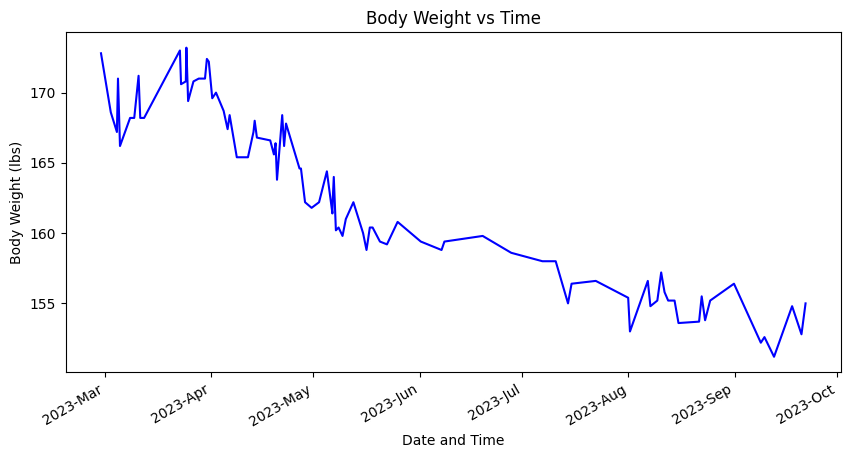

In [41]:

#x = [datetime.strptime(row[0], '%m/%d/%Y %H:%M:%S') for row in rows_body_weight]

#y = [float(row[8]) for row in rows_body_weight]

def get_coord_pairs_from_user(user, criteria):
    coord_pairs = []
    x = []
    y = []
    for child in users.get_child(user).get_child("data").children:
        if child.get_child(criteria).value != None:
            coord_pairs.append([datetime.strptime(child.get_child("timestamp").value, '%m/%d/%Y %H:%M:%S'),child.get_child("body_weight").value])
            x.append(datetime.strptime(child.get_child("timestamp").value, '%m/%d/%Y %H:%M:%S'))
            y.append(child.get_child(criteria).value)
    return coord_pairs, x, y

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))
# Set locator for x-axis
#ax.xaxis.set_major_locator(MaxNLocator(nbins=12))
# Set locator for y-axis
#ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
#ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
# Text in the x-axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

#print(get_coord_pairs_from_user("user0"))
#plt.ylim(min(get_coord_pairs_from_user("user0", "body_weight")[2])-5, max(get_coord_pairs_from_user("user0", "body_weight")[2])+5)
#plt.yticks([25,50,75,100,125,150,175,200,225,250])

x = []
y = []
x = get_coord_pairs_from_user("user0", "body_weight")[1]
y = get_coord_pairs_from_user("user0", "body_weight")[2]

plt.plot(x, y, 'b')

#alex
#x = get_coord_pairs_from_user("user1", "body_weight")[1]
#y = get_coord_pairs_from_user("user1", "body_weight")[2]

#plt.plot(x, y, 'go')

# Set labels and title
plt.xlabel('Date and Time')
plt.ylabel('Body Weight (lbs)')
plt.title('Body Weight vs Time')

# Format x-axis date
plt.gcf().autofmt_xdate()  # Rotate date labels for better visibility

# Show the plot
#plt.show()

In [32]:
sheet_id = '1CxCLvg2CGSHYNWskSa8JlBOPmF4th4XPEQQfy6AouYw'
xls = pd.ExcelFile(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx")

tab1 = pd.read_excel(xls, 'data', header = 1)

tab1

,2023-02-26 20:10:24.513000,Bench,straight,barbell,1,155,8,7,Unnamed: 8,Unnamed: 9,sdimov77@gmail.com,Unnamed: 11,155.1,6,1240,9670,44983
0,2023-02-26 20:12:48.526,Bench,straight,barbell,2.0,155,8.0,8.0,NaN,NaN,sdimov77@gmail.com,NaN,155,4.0,1240.0,9670.0,44983
1,2023-02-26 20:15:59.527,Bench,straight,barbell,3.0,155,8.0,9.0,NaN,NaN,sdimov77@gmail.com,NaN,155,6.0,1240.0,9670.0,44983
2,2023-02-26 20:19:36.136,Bench,straight,barbell,4.0,155,8.0,8.0,NaN,NaN,sdimov77@gmail.com,NaN,155,51.0,1240.0,9670.0,44983
3,2023-02-26 20:22:57.518,tricep pull,single arm,cable,1.0,25,3.0,8.0,NaN,NaN,sdimov77@gmail.com,NaN,NaN,NaN,75.0,9670.0,44983
4,2023-02-26 20:24:43.467,tricep pull,single arm,cable,2.0,20,6.0,7.0,NaN,NaN,sdimov77@gmail.com,NaN,NaN,NaN,120.0,9670.0,44983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
737,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
738,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
739,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
